In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_manager import AdvImages
from train_cnn_mnist import CNNTrain

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

from attack_pgd import projected_gradient_descent
from attack_cw import carlini_wagner_l2

from utils import init_dir, attack_and_save_adv_imgs

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

C:\Users\crama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def torch_img_show(image, label):
  npimg = image.cpu().numpy()
  fig = plt.figure(figsize = (5, 15))
  plt.imshow(image, cmap='gray')
  plt.title(label)
  plt.show()

In [3]:
trainer = CNNTrain()
trainer.model_train()

model = trainer.model
model.eval()
mnist = trainer.mnist

CNN model loaded


True Label: 7, Predcited: 7


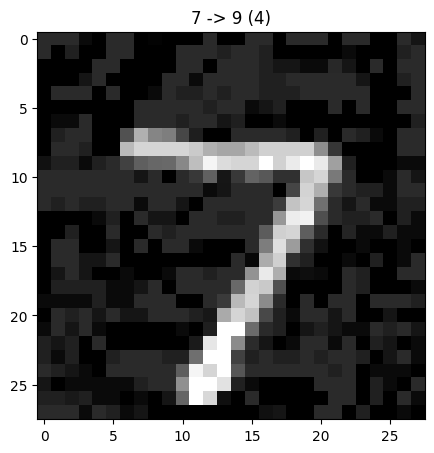

In [4]:
# Prepare data
images, labels = next(iter(mnist.test_loader))

true_y = labels.item()
pred_y = torch.argmax(model(images)).item()
print(f"True Label: {true_y}, Predcited: {pred_y}")

# PGD Attack
adv_image, n_step, pred_y = projected_gradient_descent(model, images, 0.1, 0.05, 40, np.inf)

# Evaluate
adv_pred = model(adv_image)
adv_pred_y = torch.argmax(adv_pred).item()

x_pgd = adv_image.detach()

title = f"{true_y} -> {adv_pred_y} ({n_step})"
torch_img_show(x_pgd[0][0], title)

# CW Attack
#x_cw = carlini_wagner_l2(model, images, 10, confidence=1)

# adv_pred2 = model(x_cw)
# adv_pred_y2 = torch.argmax(adv_pred2).item()

#x_cw = x_cw.detach()

# title = f"{true_y} -> {adv_pred_y2}"
# torch_img_show(x_cw[0][0], title)

In [ ]:
# save attacked images
base = "pgd_data"
# init_dir(base)
# attack_and_save_adv_imgs(model, mnist.data_test, base)

In [5]:
def test_adv_imgs(images, divide=500, nb_iter=40, rand_init=True, verbose=False):
  total = len(images) // divide

  n_steps = []
  attacked_images = []
  labels = []
  pred_ys = []
  for idx in range(0, total):
    image, label = images[idx]
    image = image.unsqueeze(0)

    #print(label)
    adv_image, n_step, pred_y = projected_gradient_descent(model, image, 0.1, 0.05, nb_iter, np.inf, rand_init=rand_init, verbose=verbose)

    attacked_images.append(adv_image.squeeze(0))
    labels.append(label)
    n_steps.append(n_step)
    pred_ys.append(pred_y)
    if ((idx+1) % (total//10) == 0):
      print(f"{100*(idx+1)/total}% ({idx+1}/{total})")
      #print(f"Label: {label}, Pred: {torch.argmax(model(adv_image), 1).item()}, n_step: {n_step}")

  adv_images = AdvImages(attacked_images, labels)

  raw_data = {'idx': range(0, total), 'label': labels, 'pred_y': pred_ys, 'n_step': n_steps}
  df = pd.DataFrame(raw_data)

  return adv_images, df

adv_images, df = test_adv_imgs(mnist.data_test, divide=10, verbose=False)

10.0% (100/1000)
20.0% (200/1000)
30.0% (300/1000)


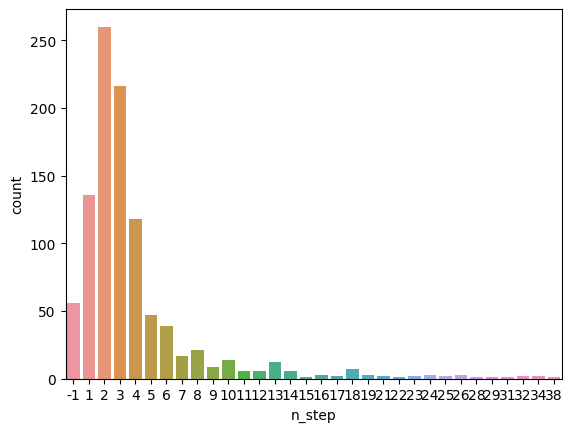

In [ ]:
import seaborn as sns

#sns.histplot(data=n_changed, kde=True)
fig = sns.countplot(x='n_step', data=df)
#fig = sns.histplot(data=n_changed)
#fig.set_xticks(range(-1, 40, 5))

In [ ]:
df

,idx,label,pred_y,n_step
0,0,7,9,4
1,1,2,1,6
2,2,1,7,4
3,3,0,6,10
4,4,4,9,3
...,...,...,...,...
995,995,2,3,2
996,996,2,1,13
997,997,0,5,7
998,998,8,3,3


10.0% (100/1000)
20.0% (200/1000)
30.0% (300/1000)
40.0% (400/1000)
50.0% (500/1000)
60.0% (600/1000)
70.0% (700/1000)
80.0% (800/1000)
90.0% (900/1000)
100.0% (1000/1000)


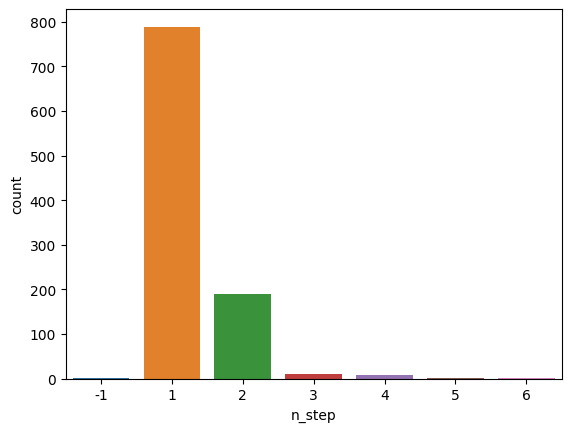

In [ ]:
pgd_reattacked, df = test_adv_imgs(adv_images, 1, nb_iter=10, rand_init=False, verbose=False)
fig = sns.countplot(x='n_step', data=df)
#fig.set_xticks(range(-1, 40, 5))

In [ ]:
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), # regularazation : range of 0~1
])

adv_data = ImageFolder(root=f'{base}/test', transform=transform_test)
adv_loader = DataLoader(dataset=adv_data, batch_size=1, shuffle=False)

def model_predict(image, label):
    with torch.no_grad():
        image_torch = image.data.view(1, 1, 28, 28).float().to(device)
        predict = model(image_torch)
        print(f"Label: {label} Predict: {torch.argmax(predict)}")
        return predict

def model_evaluate(test_loader):
    test_loss = 0
    correct_cnt = 0
    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        model.eval()
        for image, label in test_loader:
            predict_logit = model(image)
            test_loss += criterion(predict_logit, label).item()
            predict = torch.argmax(predict_logit)
            correct_cnt += predict.eq(label.view_as(predict)).sum().item()
        print(f"Loss: {test_loss:.2f}, Correct: {(correct_cnt/len(test_loader))*100:.2f}% = {correct_cnt}/{len(test_loader)}")
        return test_loss, correct_cnt

images, labels =adv_data[1]
pred = model_predict(images[0], labels)
model_evaluate(adv_loader)
print("")

Label: 0 Predict: 0
Loss: 152587.19, Correct: 2.20% = 220/10000



Using an autoencoder to distinguish adversarial examples

In [ ]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28*28),
            torch.nn.Sigmoid(),
        )
    
    def forward(self, x):
       out = x.view(x.size(0), -1)
       encoded = self.encoder(out)
       decoded = self.decoder(encoded)
       return decoded


path = "ae_model/ae_model.pt"
if(os.path.isfile(path)):
    autoencoder = torch.load(path)
else:
    autoencoder = AutoEncoder().to(device)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
    loss = torch.nn.MSELoss().to(device)

    # trains model
    for epoch in range(15):
        avg_cost = 0

        for X, Y in mnist.train_loader:
            # image is already size of (28x28), no reshape
            # label is not one-hot encoded
            X = X.to(device)
            optimizer.zero_grad()

            autoencoder.train()
            hypothesis = autoencoder(X).reshape(-1, 28, 28)
            cost = loss(hypothesis, X)
            cost.backward()
            optimizer.step()

            avg_cost += cost / 15

        print(f'[Epoch: {(epoch+1):>4}] cost = {avg_cost:>.9}')

    autoencoder.train()
    torch.save(autoencoder, "ae_model/ae_model.pt")


Calculate the difference between AE inputs and outputs

In [ ]:
def cal_mnist_diff(ae_model, loader, range, avg=0, std=0):
  idx = 0
  o_diff_sum = []

  for image, label  in loader:
    decoded = ae_model(image)

    o_diff = torch.abs(image.reshape(-1, 28*28) - decoded)
    sum = torch.sum(o_diff, axis=1).item()
    o_diff_sum.append(sum)
  #print(o_diff_sum)

  o_diff_sum = np.array(o_diff_sum)
  print(o_diff_sum.shape)
  # for training (calculate avg and std)
  if(avg == 0 and std == 0):
    avg = np.average(o_diff_sum)
    std = np.std(o_diff_sum)
    print(f"[Avg]: {avg:.2f} [Std]: {std:.2f} [Range]: {avg-std*range:.2f} ~ {avg+std*range:.2f}")

  # Search indices that is out of range
  search_result = np.where((o_diff_sum > avg+std*range) | (o_diff_sum  < avg-std*range))

  n_total = len(o_diff_sum)
  n_out_of_bound = len(search_result[0])

  print(f"[Out-of-bound Ratio]]: {(n_out_of_bound/n_total)*100:.2f}% ({n_out_of_bound}/{n_total})")
  return o_diff_sum, avg, std

diff, avg, std = cal_mnist_diff(autoencoder, mnist.data_train, 5)
test_diff = cal_mnist_diff(autoencoder, mnist.data_test, 5, avg, std)

(60000,)
[Avg]: 119.25 [Std]: 15.71 [Range]: 40.71 ~ 197.79
[Out-of-bound Ratio]]: 0.01% (9/60000)
(10000,)
[Out-of-bound Ratio]]: 0.01% (1/10000)


In [ ]:
ae_diff = cal_mnist_diff(autoencoder, adv_loader, 5, avg, std)

(10000,)
[Out-of-bound Ratio]]: 0.21% (21/10000)


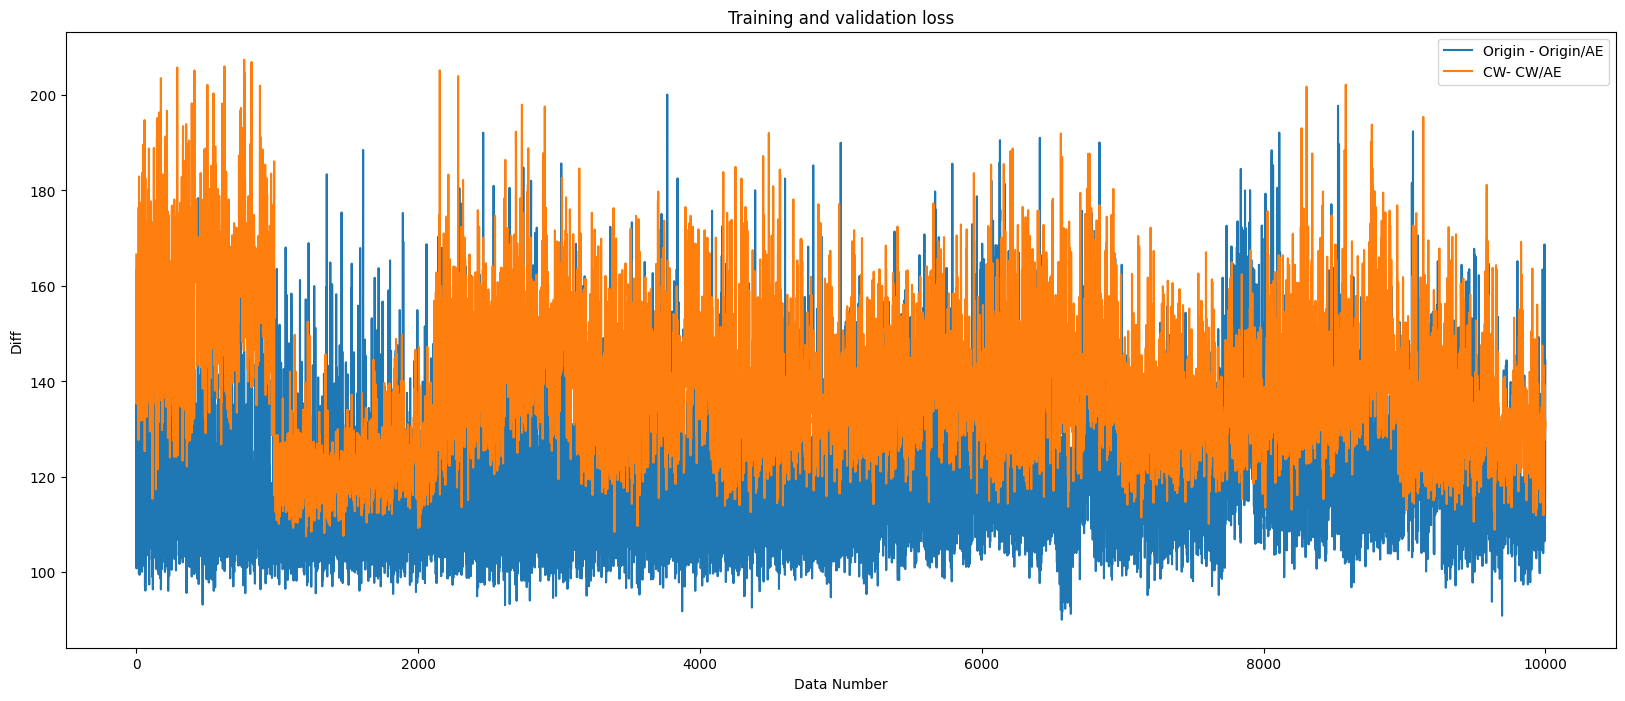

In [ ]:
data_num = range(0, len(mnist.data_test))
plt.figure(figsize=(20, 8))
plt.plot(data_num, test_diff[0], label="Origin - Origin/AE")
plt.plot(data_num, ae_diff[0], label="CW- CW/AE")
plt.title('Training and validation loss')
plt.xlabel('Data Number')
plt.ylabel('Diff')
plt.legend()
plt.show()